In [93]:
from astropy import coordinates, units as u
from astroplan import FixedTarget
from astroplan.plots import plot_airmass 
import matplotlib.pyplot as plt 
from astroplan import Observer
from astropy import units as u
from astropy.time import Time
from astroplan.plots import plot_finder_image
from astroquery.vizier import Vizier
import matplotlib.pyplot as pl
from astroplan.plots import plot_sky
from astroquery.simbad import Simbad
from astropy import constants
import numpy as np

In [71]:
betelgeuse_coord = coordinates.SkyCoord.from_name('Betelgeuse')

In [72]:
betelgeuse_target = FixedTarget(betelgeuse_coord, name='Betelgeuse')

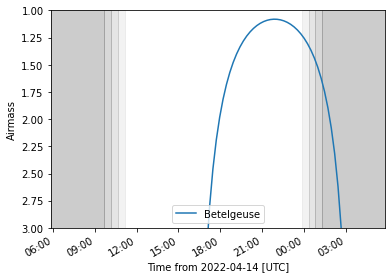

In [73]:
now = Time.now()
CTO = Observer(location=coordinates.EarthLocation(lat=29.643018, lon=-82.349004*u.deg, height=31*u.m),
               timezone='US/Eastern',
               name='University of Florida Campus Teaching Observatory')
plot_airmass([betelgeuse_target],
             observer=CTO,
             time=now,
             brightness_shading=True)

plt.legend(loc='best')
plt.show()

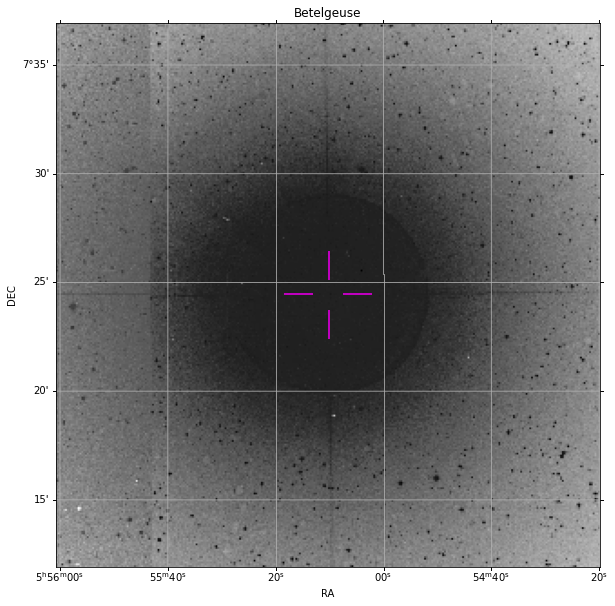

In [74]:
pl.figure(figsize=(10, 10))
ax, hdu = plot_finder_image(betelgeuse_target, survey='DSS', fov_radius=25*u.arcmin, reticle=True)

In [75]:
Vizier.ROW_LIMIT = 10000
landolt_catalog = Vizier.get_catalogs('VI/135/table8')
landolt_tbl = landolt_catalog[0]
landolt_tbl.show_in_notebook(display_length=5)

idx,Name,RAJ2000,DEJ2000,Vmag,B-V,U-B,V-R,V-I,DLType,J2mag,H2mag,K2mag,d2m
,,"""h:m:s""","""d:m:s""",mag,mag,mag,mag,mag,,mag,mag,mag,arcsec
0,Tphe-I,00 30 04.593,-46 28 10.17,14.820,0.764,0.338,0.422,0.817,,13.473,13.060,12.994,0.1
1,Tphe-A,00 30 09.594,-46 31 28.91,14.651,0.793,0.380,0.435,0.841,,13.217,12.818,12.678,0.1
2,Tphe-H,00 30 09.683,-46 27 24.30,14.942,0.740,0.225,0.425,0.851,,13.547,13.190,13.075,0.1
3,Tphe-B,00 30 16.313,-46 27 58.57,12.334,0.405,0.156,0.262,0.535,,11.276,10.967,10.914,0.1
4,Tphe-C,00 30 16.980,-46 32 21.40,14.376,-0.298,-1.217,-0.148,-0.360,,15.103,15.249,15.483,0.0
5,Tphe-D,00 30 18.342,-46 31 19.85,13.118,1.551,1.871,0.849,1.663,,10.280,9.474,9.259,0.0
6,Tphe-J,00 30 23.020,-46 23 51.60,13.434,1.465,1.229,0.980,2.043,,10.273,9.619,9.381,0.1
7,Tphe-F,00 30 49.820,-46 33 24.07,12.475,0.853,0.534,0.492,0.929,,10.886,10.516,10.349,0.2
8,Tphe-K,00 30 56.315,-46 23 26.04,12.935,0.806,0.402,0.473,0.909,,11.572,11.330,11.286,0.1


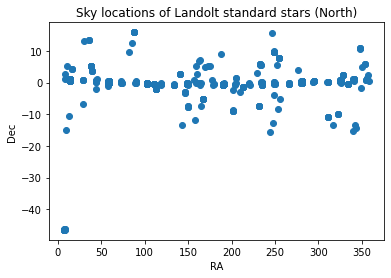

In [76]:
landolt_coords = coordinates.SkyCoord(landolt_tbl['RAJ2000'], landolt_tbl['DEJ2000'], unit=(u.h, u.deg))
_=plt.plot(landolt_coords.ra, landolt_coords.dec, 'o')
_=plt.xlabel("RA")
_=plt.ylabel("Dec")
_=plt.title("Sky locations of Landolt standard stars (North)")

In [77]:
from astroplan import Observer
from astropy import units as u # shortcut
CTO = Observer(location=coordinates.EarthLocation(lat=29.643018, lon=-82.349004*u.deg, height=31*u.m),
               timezone='EST',
               name='University of Florida Campus Teaching Observatory',
              )

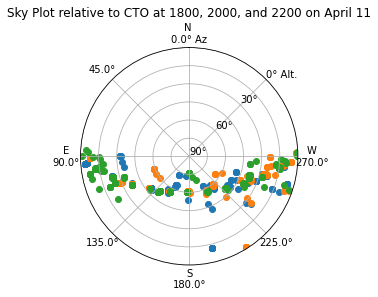

In [78]:
_=plot_sky(target=landolt_coords, observer=CTO, time=Time('2021-04-11 18:00:00'))
_=plot_sky(target=landolt_coords, observer=CTO, time=Time('2021-04-11 20:00:00'))
_=plot_sky(target=landolt_coords, observer=CTO, time=Time('2021-04-11 22:00:00'))
_=plt.title("Sky Plot relative to CTO at 1800, 2000, and 2200 on April 11")

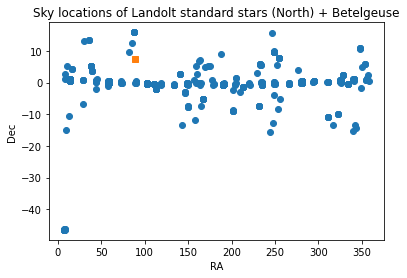

In [79]:
b_coord = coordinates.SkyCoord.from_name('Betelgeuse')
_=plt.plot(landolt_coords.ra, landolt_coords.dec, 'o')
_=plt.plot(b_coord.ra, b_coord.dec, 's')
_=plt.xlabel("RA")
_=plt.ylabel("Dec")
_=plt.title("Sky locations of Landolt standard stars (North) + Betelgeuse")

In [80]:
distances_from_b_to_standards = b_coord.separation(landolt_coords)
index = np.argmin(distances_from_b_to_standards)
landolt_tbl[index]

Name,RAJ2000,DEJ2000,Vmag,B-V,U-B,V-R,V-I,DLType,J2mag,H2mag,K2mag,d2m
,"""h:m:s""","""d:m:s""",mag,mag,mag,mag,mag,,mag,mag,mag,arcsec
str11,str12,str12,float32,float32,float32,float32,float32,str7,float32,float32,float32,float32
G102-22,05 42 09.273,+12 29 21.60,11.509,1.621,1.134,1.211,2.800,,7.124,6.627,6.389,5.8


In [84]:
print("V Magnitude of standard star: ",landolt_tbl[index]['Vmag'])
print("B Magnitude of standard star: ",landolt_tbl[index]['Vmag'] + landolt_tbl[index]['B-V'])
print("R Magnitude of standard star: ",landolt_tbl[index]['Vmag'] - landolt_tbl[index]['V-R'])

V Magnitude of standard star:  11.509
B Magnitude of standard star:  13.13
R Magnitude of standard star:  10.298


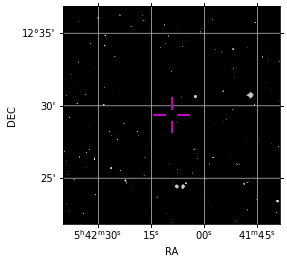

In [89]:
ax, hdu = plot_finder_image(landolt_coords[index], survey='DSS',
                            fov_radius=15*u.arcmin, grid=False,
                            reticle=True, style_kwargs={'vmin':10000, 'vmax':14000, 'cmap':'gray'})

In [92]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('flux(R)', 'flux(V)')
b_simbad = Simbad.query_object('Betelgeuse')
b_simbad

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_R,FLUX_V,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,int32
* alf Ori,05 55 10.3053,+07 24 25.430,9,9,9.040,5.720,90,A,O,2007A&A...474..653V,-1.17,0.42,1


In [101]:
A_CTO = (np.pi)*((14/2)*2.54*u.cm)**2

In [116]:
F_red = 10**(1.17/2.5) * 2500*u.Jy

nu = ((constants.c)/(6500e-10*u.m)).to(u.Hz)
dlam = 1000*u.AA
lam = 6500*u.AA 
dnu = (dlam/lam)*((constants.c)/(6500e-10*u.m)).to(u.Hz)

E_red = (F_red*A_CTO*dnu).to(u.erg/u.s)

h = constants.h
E_phot_red = h*nu

phot_per_s = (E_red.to(u.erg/u.s))/(E_phot_red.to(u.erg))

npix = phot_per_s/(65536*(1/u.s))

integration_time = (100**2)/phot_per_s

psf_area = 2 * np.pi * (2*u.arcsec)**2

pixel_scale = 0.5*u.arcsec
psf_area_pixels = psf_area * pixel_scale**-2

readnoise_per_pix = 10*u.adu/u.pix
readnoise_sum = ((psf_area_pixels*readnoise_per_pix**2)**(1/2))*u.pix

signal = (integration_time*u.s)*(phot_per_s*(1/u.s))
photon_noise = ((signal)**(1/2))

total_noise = ((signal+(photon_noise)**2)**(1/2))*u.adu

signal = (integration_time*u.s)*(phot_per_s*(1/u.s))
snr = signal**(1/2)

SNR = 100
target_signal = SNR**2 + (SNR**4 + 4*readnoise_sum.value*SNR**2)**0.5 / 2

integration_time_including_readnoise = target_signal / phot_per_s

integration_time_including_readnoise

<Quantity 8.91604426e-06 s>